# Peparacion del data frame

## Configuración inicial y carga de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

Cargar archivo

In [2]:
import csv

with open('Anexo ET_demo_round_traces_2022.csv') as csvfile:
    df = pd.read_csv(csvfile, sep=";")

Limpiar nulos

In [3]:
df.dropna(how='any', inplace=True)
null_values_new = df.isnull().sum()
print(null_values_new[null_values_new > 0])

Series([], dtype: int64)


Quitar variables con las que no se van a usar en el modelo

In [4]:
#droped_vars = ("AbnormalMatch","TravelledDistance","Map","InternalTeamId","MatchId",
#               "RoundId","RoundWinner","Survived","RLethalGrenadesThrown","RNonLethalGrenadesThrown",
#               "PrimaryAssaultRifle","PrimarySniperRifle","PrimaryHeavy","PrimarySMG","PrimaryPistol",
#               "RoundAssists","RoundHeadshots","RoundFlankKills","MatchFlankKills","MatchAssists","MatchHeadshots",
#               "MatchKills","Unnamed: 0")

droped_vars = ("AbnormalMatch", "Unnamed: 0","TravelledDistance","MatchId","InternalTeamId","RoundId")

for var in droped_vars:
  df = df.drop(var, axis=1)


transformar objeto a int

In [5]:
# Transformar variables Objecto a int
try:
  df['TimeAlive'] = pd.to_numeric(df['TimeAlive'].str.replace('.', ''))
  df['FirstKillTime'] = pd.to_numeric(df['FirstKillTime'].str.replace('.', ''))
except Exception as e:
  print(f'{e}\n')


Transformar las variables categoricas Team y MatchWinner a binario.

Team:
* Terrorist: 0
* CounterTerrorist: 1

MatchWinner:
* True: 1
* False: 0

RoundWinner:
* True: 1
* False: 0

In [6]:
df.Team.replace(to_replace=['Terrorist', 'CounterTerrorist'], value=[0, 1], inplace=True )
df.MatchWinner.replace(to_replace=['False', 'True'], value=[0, 1], inplace=True )
df.RoundWinner.replace(to_replace=['False', 'True'], value=[0, 1], inplace=True )

for var in ("Team", "MatchWinner","RoundWinner"):
    df[var] = df[var].astype(int)

Map:
* de_inferno: 0
* de_nuke: 1
* de_mirage: 2 
* de_dust2: 3

In [7]:
df.Map.replace(to_replace=['de_inferno', 'de_nuke','de_mirage','de_dust2'], 
               value=list(range(0,4)), 
               inplace=True )

df['Map'] = df['Map'].astype(int)


In [8]:
df.head()

,Map,Team,RoundWinner,MatchWinner,Survived,TimeAlive,RLethalGrenadesThrown,RNonLethalGrenadesThrown,PrimaryAssaultRifle,PrimarySniperRifle,PrimaryHeavy,PrimarySMG,PrimaryPistol,FirstKillTime,RoundKills,RoundAssists,RoundHeadshots,RoundFlankKills,RoundStartingEquipmentValue,TeamStartingEquipmentValue,MatchKills,MatchFlankKills,MatchAssists,MatchHeadshots
0,0,0,0,1,False,51120248995704500,0,4,0.0,0.0,0.0,0.0,1,0,0,0,0,0,750,4400,0,0,0,0
1,0,0,0,1,False,4348662552266170,0,0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,800,4400,0,0,0,0
2,0,0,0,1,False,3735469847054540,0,0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1000,4400,0,0,0,0
3,0,0,0,1,False,4767886136441470,0,0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,850,4400,0,0,0,0
4,0,0,0,1,True,5312251089027310,1,1,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1000,4400,0,0,0,0


## Objetivo

Utilizar las variables para determinar el tiempo de vida (TimeAlive) del jugador

In [15]:
import sklearn.metrics
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [10]:
goal = "MatchKills"

x = df.drop(goal,axis=1)
y = df[goal]
Xtrain, Xtest, Ytrain, Ytest = train_test_split(x,y,test_size=0.2)

In [11]:
model = DecisionTreeRegressor()

import math

params_features = np.arange(
                math.trunc(len(df.columns)/3),
                len(df.columns)
                )

params = {"max_depth": np.arange(1,20,2),
          "min_samples_split": np.arange(10,20,2),
          "max_features": params_features
          }

grid = GridSearchCV(estimator=model, param_grid=params,cv=10)
grid.fit(Xtrain, Ytrain)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'max_features': array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]),
                         'min_samples_split': array([10, 12, 14, 16, 18])})

In [12]:
print(grid.best_score_)
print(grid.best_params_)

0.7977872600817985
{'max_depth': np.int64(9), 'max_features': np.int64(22), 'min_samples_split': np.int64(16)}


In [13]:
best_estimator = grid.best_estimator_

In [17]:
Yhat = best_estimator.predict(Xtest)

mae = mean_absolute_error(Ytest, Yhat)
r2 = r2_score(Ytest, Yhat)

print("mean absolute error: ",mae)
print("r2: ",r2)

mean absolute error:  2.0062245968126904
r2:  0.7998754812283599


In [18]:
features = best_estimator.feature_importances_
feature_names = best_estimator.feature_names_in_
print(pd.DataFrame(features, columns = ["Imp"], index =feature_names).sort_values(by = 'Imp', ascending = False))

                                  Imp
MatchHeadshots               0.818325
MatchFlankKills              0.114506
MatchAssists                 0.024284
PrimarySniperRifle           0.012313
FirstKillTime                0.011904
RoundStartingEquipmentValue  0.004941
Team                         0.003131
MatchWinner                  0.002572
TeamStartingEquipmentValue   0.001721
Map                          0.001528
RoundKills                   0.001369
RoundHeadshots               0.001334
TimeAlive                    0.000988
RoundFlankKills              0.000530
RNonLethalGrenadesThrown     0.000267
RoundAssists                 0.000112
RLethalGrenadesThrown        0.000086
PrimarySMG                   0.000050
PrimaryAssaultRifle          0.000038
Survived                     0.000000
RoundWinner                  0.000000
PrimaryPistol                0.000000
PrimaryHeavy                 0.000000


Graficos

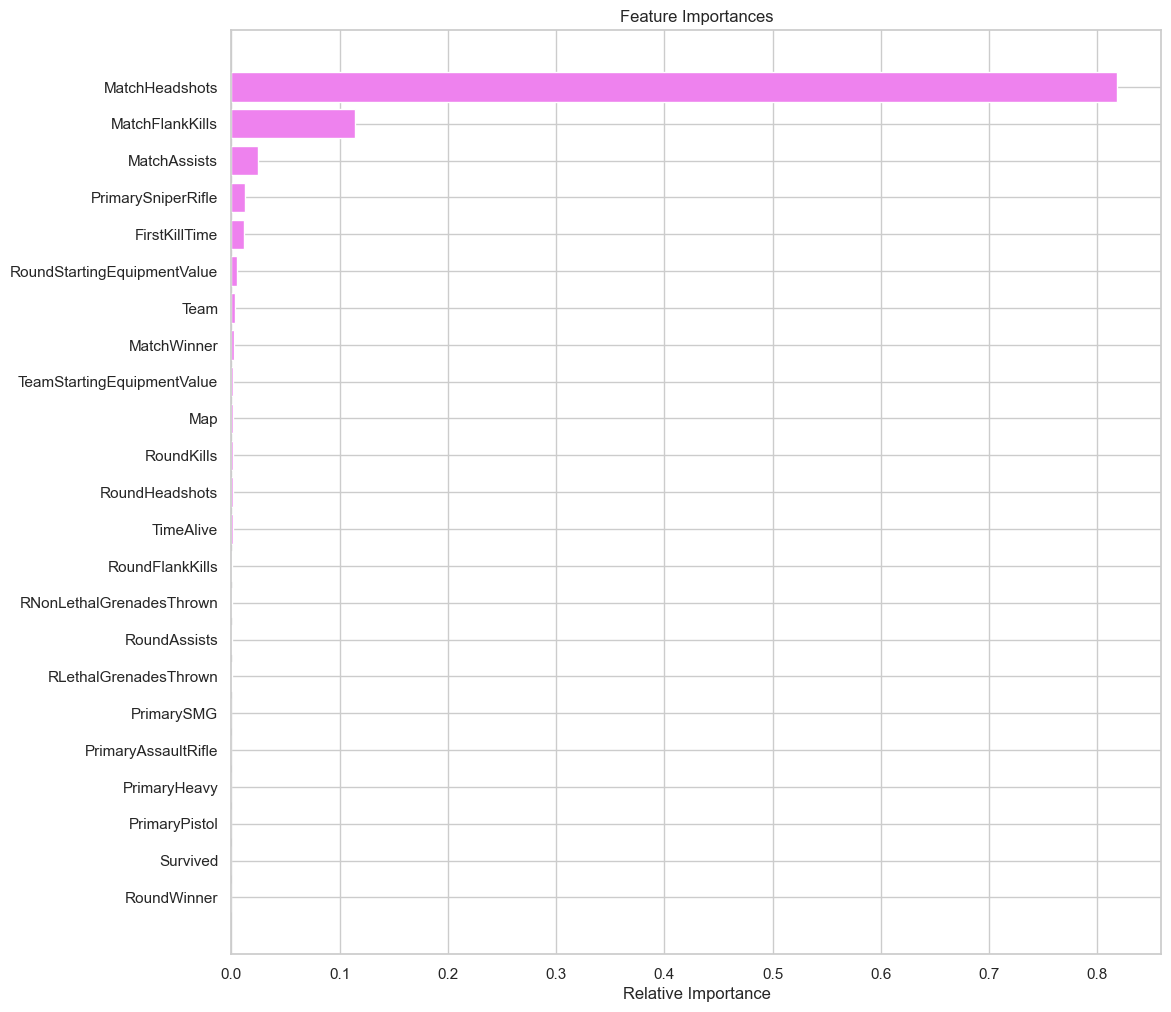

In [19]:
# Plotting feature importances
indices = np.argsort(features)
 
plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), features[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


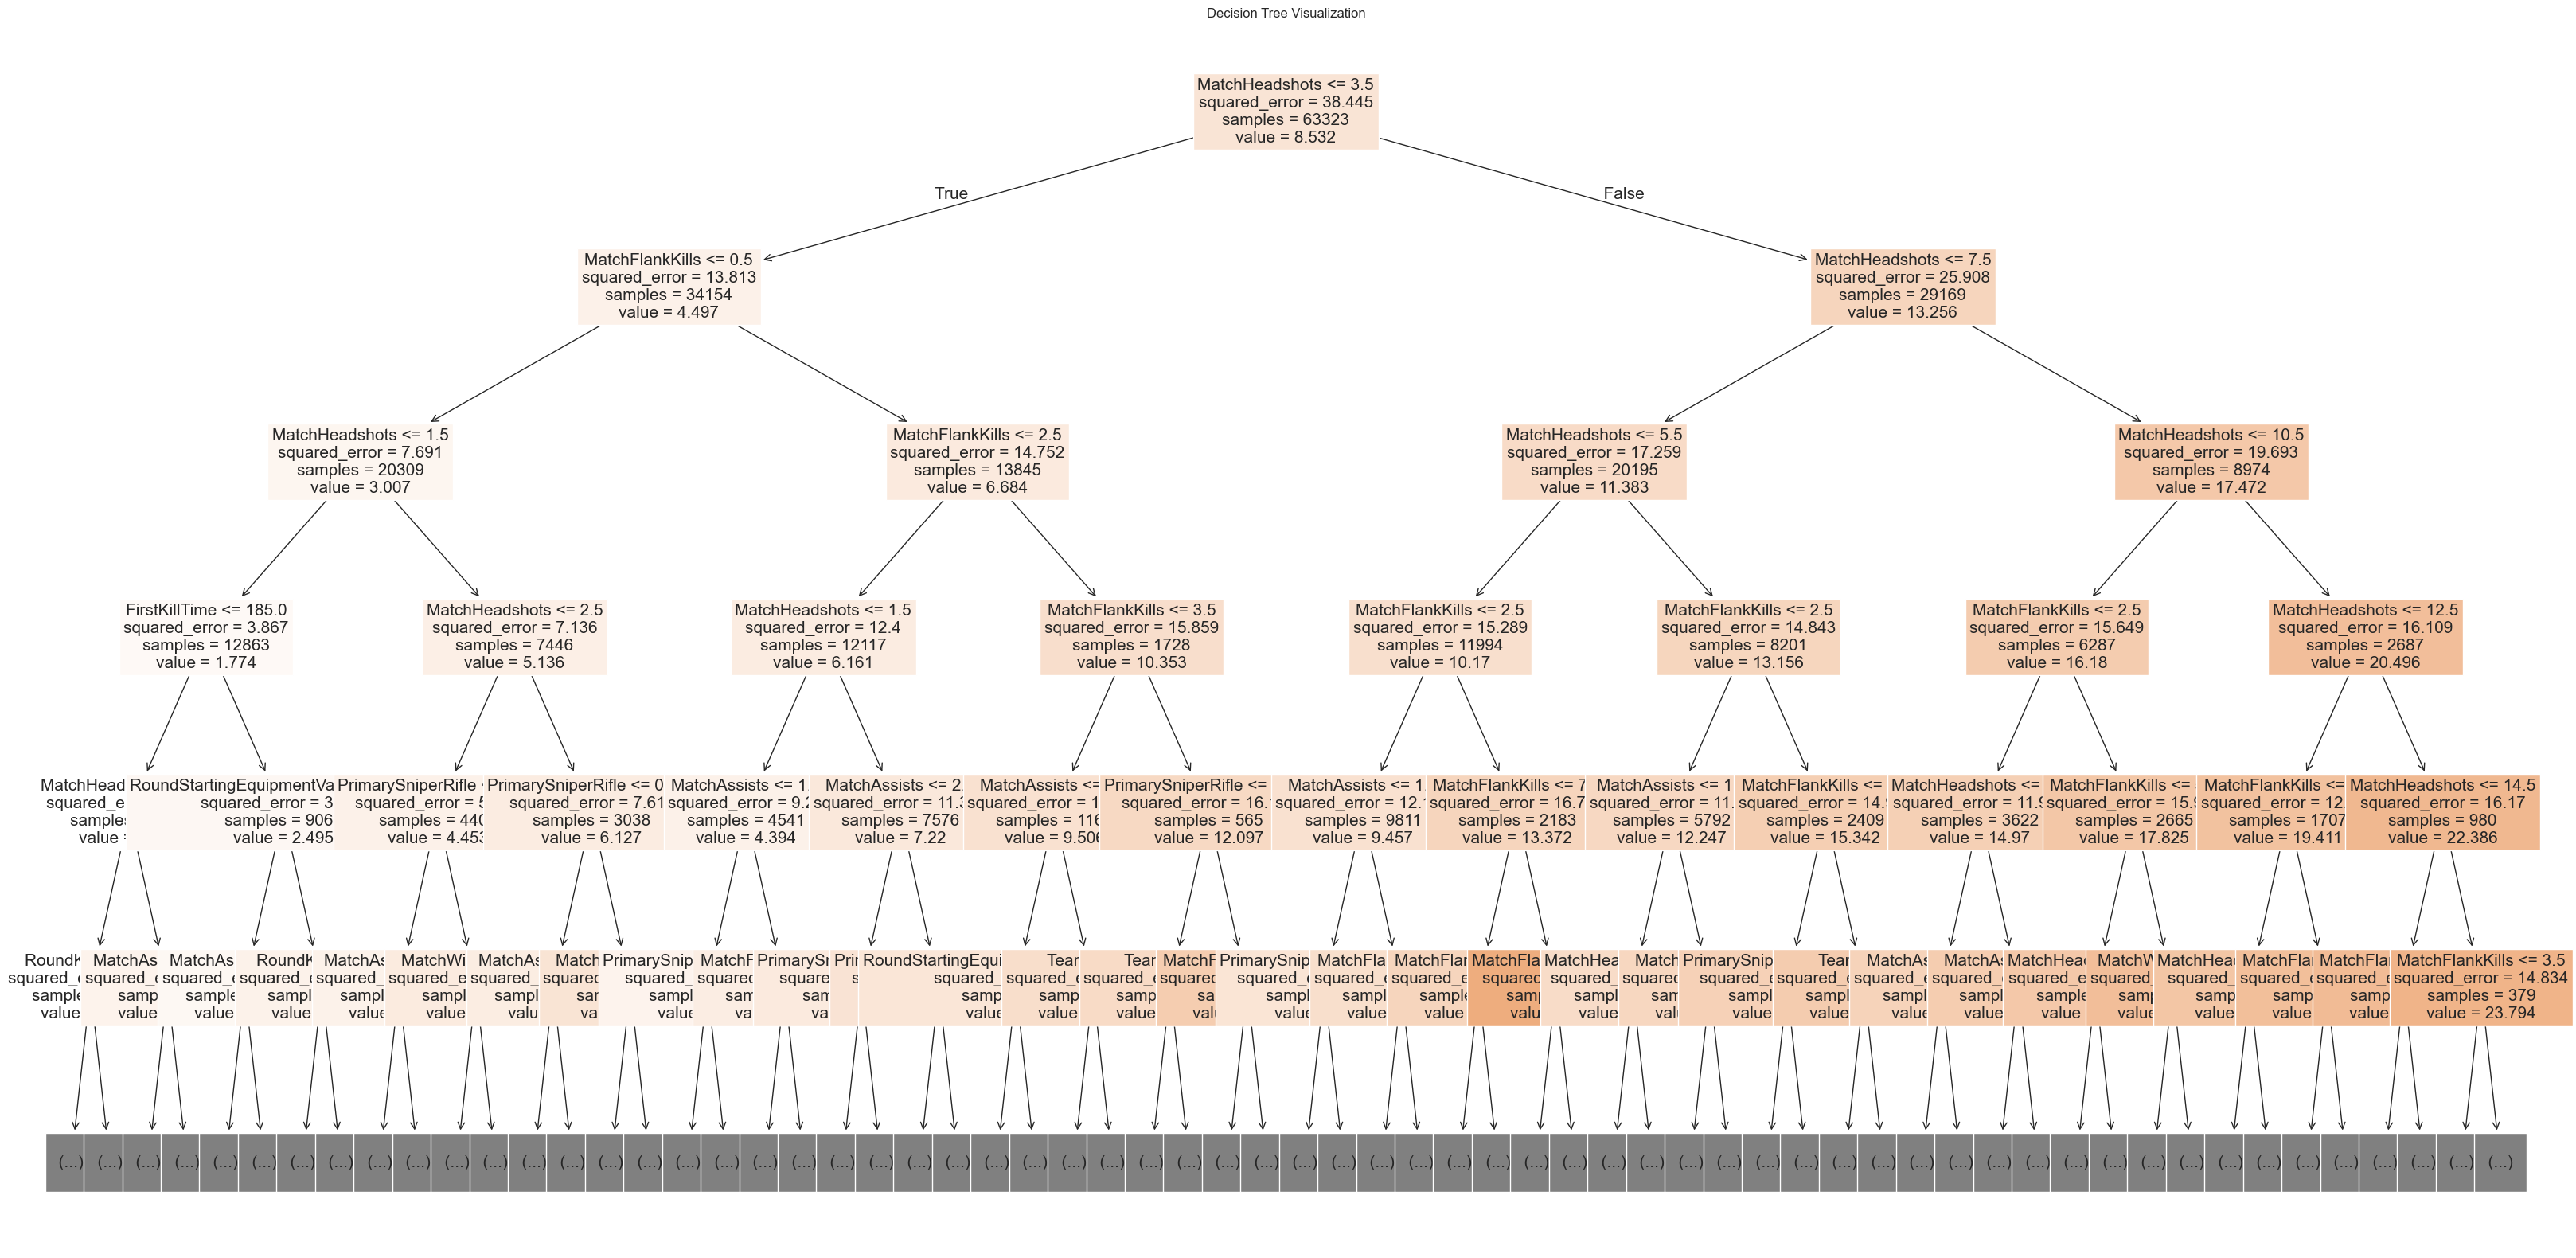

In [20]:
from sklearn.tree import plot_tree

plt.figure(figsize=(40, 20))
plot_tree(best_estimator, filled=True, 
          feature_names=feature_names,
          max_depth=5,fontsize=15)
plt.title('Decision Tree Visualization')
plt.show()